# Object recognition with keras

<img src="https://media.giphy.com/media/l0MYxW1PyZl1qEA1O/giphy.gif" align="right" width="250" />

Hi again! Let's do some object recognition with keras! We'll make a CNN from the ground up, one that's specialized to **recognize hand drawn doodles**. "Like pictionary?" Yes exactly like pictionary!

We've seen the basics of how CNN's process visual data in [the previous section](./1.convolutional_neural_networks), we'll compose a net that accepts a picture you draw yourself and guess what's on it! This may not have that much practical use, but it serves as a nice **learning experience** on how neural nets work step by step before you tackle the challenges ahead!

We'll use part of google's generously documented ['quick, draw!' dataset](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/simplified) to train our model.

We're using the simplified dataset, but still, there are too many categories to download all of them! That's alright, **pick out two classes** and download them to your machine for use, you'll use those in this notebook for object recognition!


## Examining the data

Let's take a look at what we dragged out of google's database. For this exercise, I'll be using the **cat** and **dog** classes, but as stated before, you can choose your own classes!

In [3]:
!wget -N https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy -P ../assets/
!wget -N https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy -P ../assets/

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


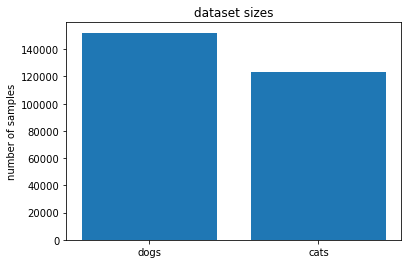

In [10]:
import numpy as np
from matplotlib import pyplot as plt
dogs = np.load("../assets/dog.npy")
cats = np.load("../assets/cat.npy")

plt.bar([0,1], [dogs.shape[0], cats.shape[0]])
plt.title('dataset sizes')
plt.xticks([0,1], ['dogs', 'cats'])
plt.ylabel('number of samples');

That's a lot of cats and dogs!

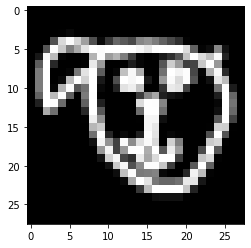

In [5]:
sample = dogs[0].reshape(28,28)
plt.imshow(sample, cmap="gray")

What a cute little doggy!

Google has been so kind to deliver us a **cleaned dataset**, the process of cleaning was as follows:

1. Align the drawing to the top-left corner, to have minimum values of 0.
2. Uniformly scale the drawing, to have a maximum value of 255.
3. Resample all strokes with a 1 pixel spacing.
4. Simplify all strokes using the Ramer–Douglas–Peucker algorithm with an epsilon value of 2.0.

This would have given them an image like the following.
![Cat Drawing (Image)](../assets/cat_drawing.png)

To get to an image like we had before, they had to transform this datatype from **vector format** to **raster format**! You might wonder why this step is necessary. Vector format retains all of the original information and is easy to store; no need to store all pixels, only 2 points for every line. BUT...convolutional neural networks want all those intermediate pixels as well! We want a **grid of pixels** to feed to our network so we can **convolve and pool** .

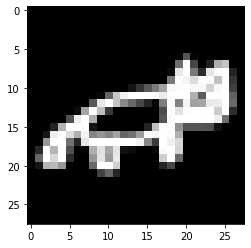

In [7]:
sample = cats[1].reshape(28,28)
plt.imshow(sample, cmap="gray")

There we go, a kitty in a raster format! When this is fed to a **CNN**, the input layer can accept this input as an **image** comprising as a 28 by 28 grid of **pixels** that are either activated or not. This way, our neural network can also **convolve** the image and **pool** the pixels. This would be a bit hard to do with the original **vector format**.

We have more than enough samples to work with, so let's take a nicely **balanced subset** of our data so we don't get bias in the final model.

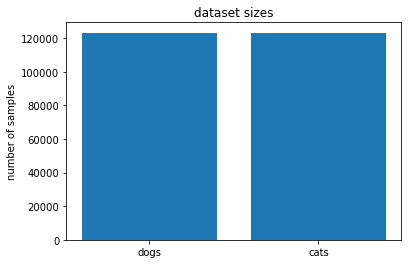

In [12]:
max_samples = min(cats.shape[0], dogs.shape[0])
preprocessed_cats = cats[:max_samples].reshape(-1,28,28)
preprocessed_dogs = dogs[:max_samples].reshape(-1,28,28)

plt.bar([0,1], [preprocessed_dogs.shape[0], preprocessed_cats.shape[0]])
plt.title('dataset sizes')
plt.xticks([0,1], ['dogs', 'cats'])
plt.ylabel('number of samples');

Now, let's add the labels as well! Our neural network won't like **string values like 'cat' and 'dog**, but will want numeric representations instead. let's use **0 for cats, and 1 for dogs**. When you handle classifiers with more than two possible classes, don't forget the one-hot encoding format! Keras has the handy [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function) function for this. For this example though, it is not needed.

In [14]:
cat_labels = np.zeros((max_samples, 1))
dog_labels = np.ones((max_samples, 1))

labels = np.concatenate([cat_labels, dog_labels])
drawings = np.concatenate([preprocessed_cats, preprocessed_dogs])

# tensorflow wants a 4D tensor with (n_images, width, height, colour_depth)
print("Drawings shape before : ", drawings.shape)
drawings = np.expand_dims(drawings, axis=3)
print("Drawings shape after : ", drawings.shape)
print("Label shape : ", labels.shape)

Drawings shape before :  (246404, 28, 28)
Drawings shape after :  (246404, 28, 28, 1)
Label shape :  (246404, 1)


One final step: **separating our dataset into a test and train set**. Let's choose a training size of 80%, and a testing size of 20%.

In [15]:
from sklearn.model_selection import train_test_split

train_drawings, test_drawings, train_labels, test_labels = train_test_split(
    drawings, 
    labels,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

print("train_drawings shape : ", train_drawings.shape)
print("test_drawings shape : ", test_drawings.shape)
print("train_labels shape : ", train_labels.shape)
print("test_labels shape : ", test_labels.shape)

train_drawings shape :  (197123, 28, 28, 1)
test_drawings shape :  (49281, 28, 28, 1)
train_labels shape :  (197123, 1)
test_labels shape :  (49281, 1)


## Composing and evaluating the model

### composing the most simple form

You've seen in [convolutional neural networks](./1.convolutional_neural_networks) the different parts of a typical CNN and how they relate to each other. **keras** makes it easy for us to quickly compose a neural network.

Let's start with the **simplist of convolutional neural networks**: A convolutional layer, followed by a flattening layer and a regular 1D dense layer. Why is this the most simple form, you ask? Well, our neural network cannot consist of only a conv layer, since these **accept and output a 2D data structure**. If the output and input layer are the same, the outputs is a very hard to interpret **2D layer**. How does this relate to our defined classes; The **cat class** and **dog class**? It doesn't, it needs to be flattened into a binary output, since we have two classes in our model.

In [17]:
from keras import layers, models

# pixel width and height of our images
input_size = 28

# number of filters in the convnet layer
filters = 32

model = models.Sequential()
model.add(layers.Conv2D(filters, kernel_size = (5, 5), activation='relu', input_shape=(input_size, input_size, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 36866     
Total params: 37,698
Trainable params: 37,698
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_drawings, train_labels, epochs=6, 
                    validation_data=(test_drawings, test_labels))

Epoch 1/6
6161/6161 [==============================] - 48s 8ms/step - loss: 0.6948 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 2/6
6161/6161 [==============================] - 50s 8ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 3/6
6161/6161 [==============================] - 48s 8ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 4/6
6161/6161 [==============================] - 48s 8ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 5/6
6161/6161 [==============================] - 48s 8ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 6/6
6161/6161 [==============================] - 49s 8ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977


Now, let's evaluate out model by comparing our **test accuracy vs the training accuracy** with the matplotlib library.

1541/1541 - 3s - loss: 0.6932 - accuracy: 0.4977


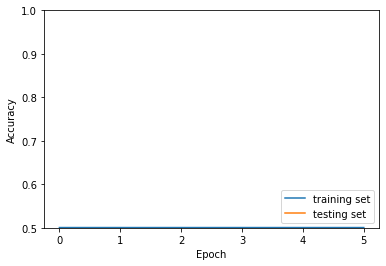

In [19]:
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_drawings,  test_labels, verbose=2)

Oof! This model is utter trash! It's randomly guessing; it only gets it right 50% of the time, which is about as good as your average blind person!

What went wrong? why can't it tell the difference between our cat and dog doodles? Is our dataset too small? is the data quality too low? Both possible, but there's another obvious cause; our model is just shit.

**Having only a single conv layer is not enough to tell the difference between cat and dog doodles**. Why? Because right now, the neural network can just about make out if an image contains lines or not, which they both obviously do! Look at the image below:

![convnet_progression](./../assets/convnet_progression.png)

Each of these stages (from bottom to top) represent a convnet layer, and what it outputs. The bottom layer has 24 filters and seems to be able to make out the lines composing the image, but it's not connecting the dots so to speak. The features extracted by the first convnet layer are given to the next, and this layer connect these features into higher order features, and so on.

So we are still stuck in the first stage, we need to **extend our model**.

### composing an extended model

Let's add another convnet layer! But in between these, we'll add a **pooling layer**. What's the purpose of this layer you ask? It has multiple purposes as seen in the last subchapter, but the main purpose here is **dimensionality reduction** to make it a bit easier on our model. Training the last model was already pretty challenging, and we don't need quantity, we need quality. Pooling (supposedly) redundant spatial information together is ofter done in CNN's for this reason.

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size = (5, 5), activation='relu', input_shape=(input_size, input_size, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(64, kernel_size = (5, 5), activation='relu', ))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 54,146
Trainable params: 54,146
Non-trainable params: 0
__________________________________________________

In [21]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_drawings, train_labels, epochs=6, 
                    validation_data=(test_drawings, test_labels))

Epoch 1/6
6161/6161 [==============================] - 110s 18ms/step - loss: 0.6938 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 2/6
6161/6161 [==============================] - 113s 18ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 3/6
6161/6161 [==============================] - 126s 20ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 4/6
6161/6161 [==============================] - 121s 20ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 5/6
6161/6161 [==============================] - 118s 19ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977
Epoch 6/6
6161/6161 [==============================] - 120s 19ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4977


1541/1541 - 9s - loss: 0.6932 - accuracy: 0.4977


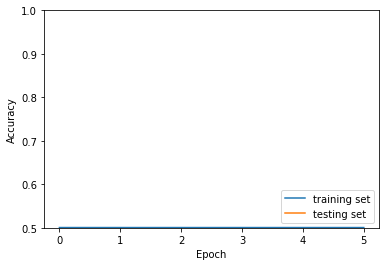

In [22]:
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_drawings,  test_labels, verbose=2)

Ouch! Still trash! What's wrong with our model? There's still a possibility that the data quality isn't up to par, but we can still improve the model regardless. Right now, our model is still lacking something vital: regular dense layers! 

Adding these layers is a nice way to finally put the extracted features together and make nonlinear connections between them! Like "aha, sharp ear features + a triangle nose means a cat, probably >.>!".


### Further extending the model with dense layers

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size = (5, 5), activation='relu', input_shape=(input_size, input_size, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(32, kernel_size = (5, 5), activation='relu', ))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                

In [24]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_drawings, train_labels, epochs=6, 
                    validation_data=(test_drawings, test_labels))

Epoch 1/6
6161/6161 [==============================] - 100s 16ms/step - loss: 0.3052 - accuracy: 0.8706 - val_loss: 0.2599 - val_accuracy: 0.8902
Epoch 2/6
6161/6161 [==============================] - 109s 18ms/step - loss: 0.2495 - accuracy: 0.8951 - val_loss: 0.2473 - val_accuracy: 0.8931
Epoch 3/6
6161/6161 [==============================] - 102s 17ms/step - loss: 0.2366 - accuracy: 0.9013 - val_loss: 0.2502 - val_accuracy: 0.8944
Epoch 4/6
6161/6161 [==============================] - 106s 17ms/step - loss: 0.2275 - accuracy: 0.9045 - val_loss: 0.2359 - val_accuracy: 0.9008
Epoch 5/6
6161/6161 [==============================] - 113s 18ms/step - loss: 0.2205 - accuracy: 0.9079 - val_loss: 0.2327 - val_accuracy: 0.9023
Epoch 6/6
6161/6161 [==============================] - 108s 18ms/step - loss: 0.2137 - accuracy: 0.9106 - val_loss: 0.2316 - val_accuracy: 0.9037


1541/1541 - 8s - loss: 0.2316 - accuracy: 0.9037


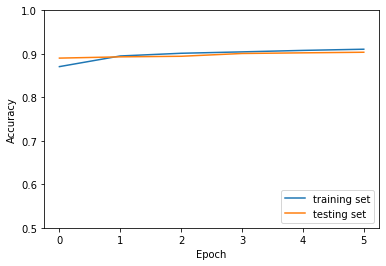

In [25]:
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_drawings,  test_labels, verbose=2)

Now we're cookin'! This is starting to look good, and it doesn't seem to be overfitted either! You might wonder what to do if the model were to be overfitted. There are a few ways to prevent this as you already know. One of them is to **decrease the DOF's of the model**, another neat method often used in CNN's is **adding dropout layers**.

"Dropout layers?! I'm no quitter!". Don't worry, these are conceptually easy to understand: These **deactivate a fraction of the neurons of the preceeding layers at random** to encourage robustness on the overall layer. Deactivating them at random avoids the reliance on specific nodes and disallows the network to overly fit to the training set.

This method isn't perfect, and it needs a decently sized network (thus a lot of parameters to train), but is common practice for these kind of networks. The next bit of code shows how you would add dropout layers that deactivate half of the preceeding layer. **For this particular model it's not needed**, but it might be necessary if you picked different (or more) classes to train on!

### Adding dropout layers

In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size = (5, 5), activation='relu', input_shape=(input_size, input_size, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(32, kernel_size = (5, 5), activation='relu', ))
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

NameError: name 'models' is not defined

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_drawings, train_labels, epochs=6, 
                    validation_data=(test_drawings, test_labels))

In [ ]:
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label = 'testing set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_drawings,  test_labels, verbose=2)

Alright, we're done with modelling, time to give it a final test; Our own drawing!

## Testing the model

The following is a piece of code designed to take inputs from the user to generate a drawing from. **This code is very case specific and there is no need for you to learn the tkinter library for computer vision**. So just enjoy the result and continue on to the [next notebook](./4.object_recognition_with_pytorch.ipynb) after you're done playing around.

In [1]:
class LineDrawer:
    
    def __init__(self, canvas, input_size, output_size = 64, brush_size = 3, line_colour = "#476042"):
        self.canvas = canvas
        self.drawing = np.zeros((output_size, output_size))
        self.mouse_is_clicked = False
        self.brush_size = brush_size
        self.line_colour = line_colour
        self.scale_factor = float(output_size)/float(input_size)

    def on_motion(self, event):
        if not self.mouse_is_clicked:
            return
        x1, y1 = (event.x - self.brush_size), (event.y - self.brush_size)
        x2, y2 = (event.x + self.brush_size), (event.y + self.brush_size)
        self.canvas.create_oval(x1, y1, x2, y2, fill=self.line_colour)
        self.drawing[round(event.y*self.scale_factor), round(event.x*self.scale_factor)] = 255

    def on_down_press(self, event):
        self.mouse_is_clicked = True

    def on_release(self, event):
        self.mouse_is_clicked = False


In [51]:
import tkinter as tk

# run this cell to get a drawing interface!
gui = tk.Tk()
canvas_size = 512
canvas = tk.Canvas(gui, width=canvas_size, height=canvas_size)
line_drawer = LineDrawer(canvas, canvas_size, 28)
canvas.bind('<Motion>', line_drawer.on_motion)
canvas.bind('<Button-1>', line_drawer.on_down_press)
canvas.bind('<ButtonRelease-1>', line_drawer.on_release)
canvas.pack()
gui.mainloop()

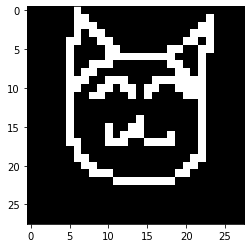

In [52]:
plt.imshow(line_drawer.drawing, cmap="gray")

In [53]:
drawing_input = line_drawer.drawing.reshape(1, 28, 28, 1)

model.predict(drawing_input)

array([[0.97285575, 0.02714424]], dtype=float32)

Amazing! our model is **97.3% sure** that little doodle I just drew with my mouse is a cat! Let's see if it can also recognise a dog!

In [59]:
# run this cell to get a drawing interface!
gui = tk.Tk()
canvas_size = 512
canvas = tk.Canvas(gui, width=canvas_size, height=canvas_size)
second_line_drawer = LineDrawer(canvas, canvas_size, 28)
canvas.bind('<Motion>', second_line_drawer.on_motion)
canvas.bind('<Button-1>', second_line_drawer.on_down_press)
canvas.bind('<ButtonRelease-1>', second_line_drawer.on_release)
canvas.pack()
gui.mainloop()

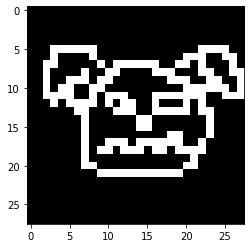

In [60]:
plt.imshow(second_line_drawer.drawing, cmap="gray")

In [61]:
drawing_input = second_line_drawer.drawing.reshape(1, 28, 28, 1)

model.predict(drawing_input)

array([[0.05562222, 0.9443777 ]], dtype=float32)

Wow, despite my lacking drawing skills, our model is still **94.4% sure** that thing is a dog!